# Problem Set 1. Content-aware image resizing: Seam Carving

In [ ]:
#Adeliya Tislova
#U43421302
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Function to compute the energy at each pixel
def energy_img(im):
  im_double = im.astype(np.float64) #Convert image to a double datatype
  #Convert image to a grayscale by multiplying weights and pixel values
  grayscale_img = 0.299 * im_double[:, :, 0] + 0.587 * im_double[:, :, 1] + 0.114 * im_double[:, :, 2]
  dy = np.gradient(grayscale_img)[0] #Compute gradient for verticals(changes between rows)
  dx = np.gradient(grayscale_img)[1] #Compute gradient for horizontals(changes between columns)
  energyImg = np.sqrt(dx**2 + dy**2) #Compute the energy function
  return energyImg #Return 2D energy matrix

In [ ]:
#Function to compute the minimum cumulative energy map for specified direction
def cumulative_min_energy_map(energyImg, seamDirection):
  cumulativeEnergyMap = np.empty_like(energyImg) #Initialize an empty map with the same dimensions as energyImg
  if seamDirection == "VERTICAL":
    cumulativeEnergyMap[0, :] = energyImg[0, :] #Copy the first row. We iterate from top to bottom
    for i in range(1, energyImg.shape[0]): #i = row. Start from the second row
      for j in range(0, energyImg.shape[1]): #j = column
        if j == 0: #Edge case(first column)
          #We can choose only from above or above right
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i - 1, j], cumulativeEnergyMap[i - 1, j + 1])
        elif j == energyImg.shape[1] - 1: #Edge case(last column)
          #We can choose only from above or above left
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i - 1, j], cumulativeEnergyMap[i - 1, j - 1])
        else: #Choose from above, above left, or above right
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i - 1, j], cumulativeEnergyMap[i - 1, j - 1], cumulativeEnergyMap[i - 1, j + 1])
  elif seamDirection == "HORIZONTAL":
    cumulativeEnergyMap[:, 0] = energyImg[:, 0] #Copy the first column. We iterate from left to right
    for j in range(1, energyImg.shape[1]): #j = column. Start from the second column
      for i in range(0, energyImg.shape[0]): #i = row
        if i == 0: #Edge case(first row)
          #We can choose only from left or lower left
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i, j - 1], cumulativeEnergyMap[i + 1, j - 1])
        elif i == energyImg.shape[0] - 1: #Edge case(last row)
          #We can choose only from left or above left
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i, j - 1], cumulativeEnergyMap[i - 1, j - 1])
        else:
          #We can choose from left, above left, or lower left
          cumulativeEnergyMap[i, j] = energyImg[i, j] + min(cumulativeEnergyMap[i, j - 1], cumulativeEnergyMap[i - 1, j - 1], cumulativeEnergyMap[i + 1, j - 1])
  return cumulativeEnergyMap #Return 2D matrix

In [ ]:
#Function to find an optimal vertical seam
def find_vertical_seam(cumulativeEnergyMap):
  verticalSeam = np.zeros(cumulativeEnergyMap.shape[0], int) #Initialize a vector for column indexes
  starting_point = np.argmin(cumulativeEnergyMap[-1, :]) #Find column index with the minimum value at the very bottom
  verticalSeam[-1] = starting_point #Store
  #Iterate from the second last row to the first row(bottom up)
  for i in range(cumulativeEnergyMap.shape[0] - 2, -1, -1):
    if starting_point == 0: #Edge case(first column)
      #We can choose only from above or above right
      values = [cumulativeEnergyMap[i, starting_point], cumulativeEnergyMap[i, starting_point + 1]]
      column_indexes = [starting_point, starting_point + 1] #Store corresponding column indexes
      find_min_index = np.argmin(values) #Find index of the minimum value from available options
      starting_point = column_indexes[find_min_index] #Find the corresponding column index
      verticalSeam[i] = starting_point #Store
    elif starting_point == cumulativeEnergyMap.shape[1] - 1: #Edge case(last column)
      #We can choose only from above or above left
      values = [cumulativeEnergyMap[i, starting_point], cumulativeEnergyMap[i, starting_point - 1]]
      column_indexes = [starting_point, starting_point - 1]
      find_min_index = np.argmin(values)
      starting_point = column_indexes[find_min_index]
      verticalSeam[i] = starting_point
    else: #All other cases
      #We can choose from above, above right, or above left
      values = [cumulativeEnergyMap[i, starting_point], cumulativeEnergyMap[i, starting_point + 1], cumulativeEnergyMap[i, starting_point - 1]]
      column_indexes = [starting_point, starting_point + 1, starting_point - 1]
      find_min_index = np.argmin(values)
      starting_point = column_indexes[find_min_index]
      verticalSeam[i] = starting_point
  return verticalSeam #Return vector with column indexes

In [ ]:
#Function to find an optimal horizontal seam
def find_horizontal_seam(cumulativeEnergyMap):
  horizontalSeam = np.zeros(cumulativeEnergyMap.shape[1], int) #Initialize a vector for row indexes
  starting_point = np.argmin(cumulativeEnergyMap[:, -1]) #Find row index with the minimum value at the very right
  horizontalSeam[-1] = starting_point #Store
  #Iterate from the second last column to the first column(right to left)
  for i in range(cumulativeEnergyMap.shape[1] - 2, -1, -1):
    if starting_point == 0: #Edge case(first row)
      #We can choose only from left or lower left
      values = [cumulativeEnergyMap[starting_point, i], cumulativeEnergyMap[starting_point + 1, i]]
      row_indexes = [starting_point, starting_point + 1] #Store corresponding row indexes
      find_min_index = np.argmin(values) #Find index of the minimum value from available options
      starting_point = row_indexes[find_min_index] #Find the corresponding row index
      horizontalSeam[i] = starting_point #Store
    elif starting_point == cumulativeEnergyMap.shape[0] - 1: #Edge case(last row)
      #We can choose only from left or above left
      values = [cumulativeEnergyMap[starting_point, i], cumulativeEnergyMap[starting_point - 1, i]]
      row_indexes = [starting_point, starting_point - 1]
      find_min_index = np.argmin(values)
      starting_point = row_indexes[find_min_index]
      horizontalSeam[i] = starting_point
    else: #All other cases
      #We can choose from left, lower left, or above left
      values = [cumulativeEnergyMap[starting_point, i], cumulativeEnergyMap[starting_point + 1, i], cumulativeEnergyMap[starting_point - 1, i]]
      row_indexes = [starting_point, starting_point + 1, starting_point - 1]
      find_min_index = np.argmin(values)
      starting_point = row_indexes[find_min_index]
      horizontalSeam[i] = starting_point
  return horizontalSeam #Return vector with row indexes

In [ ]:
#Function to display the seam
def view_seam(im, seam, seamDirection):
  plt.imshow(im) #Display as the image
  if seamDirection == "VERTICAL":
    plt.plot(seam, range(im.shape[0]), color = "red") #Plot vertical seam using column indexes and row indexes
    plt.title("Vertical seam") #Create a title
  elif seamDirection == "HORIZONTAL":
    plt.plot(range(im.shape[1]), seam, color = "red") #Plot horizontal seam using column indexes and row indexes
    plt.title("Horizontal seam") #Create a title
  plt.show() #Show the final image
  return

In [ ]:
#Function to decrease width by 1 pixel
def decrease_width(im, energyImg):
  reducedColorImg = np.empty((im.shape[0], im.shape[1] - 1, 3), im.dtype) #Output matrix with reduced width with the same data type as the original image
  cumulativeEnergyMap = cumulative_min_energy_map(energyImg, "VERTICAL") #Compute cumulative energy map for vertical direction
  verticalSeam = find_vertical_seam(cumulativeEnergyMap) #Find column indexes
  #Iterate over each row
  for i in range(im.shape[0]):
    column_index = verticalSeam[i] #Save index
    #Perform slicing and concatenate left and right sides removing vertical seam
    reducedColorImg[i, :, :] = np.concatenate((im[i, :column_index, :], im[i, column_index + 1:, :]))
  reducedEnergyImg = energy_img(reducedColorImg) #Compute new energy matrix
  return reducedColorImg, reducedEnergyImg #Return matrix with reduced width and updated energy matrix

In [ ]:
#Function to decrease height by 1 pixel
def decrease_height(im, energyImg):
  reducedColorImg = np.empty((im.shape[0] - 1, im.shape[1], 3), im.dtype) #Output matrix with reduced height with the same data type as the original image
  cumulativeEnergyMap = cumulative_min_energy_map(energyImg, "HORIZONTAL") #Compute cumulative energy map for horizontal direction
  horizontalSeam = find_horizontal_seam(cumulativeEnergyMap) #Find row indexes
  #Iterate over each column
  for i in range(im.shape[1]):
    row_index = horizontalSeam[i] #Save index
    #Perform slicing and concatenate upper and bottom parts removing horizontal seam
    reducedColorImg[:, i, :] = np.concatenate((im[:row_index, i, :], im[row_index + 1:, i, :]))
  reducedEnergyImg = energy_img(reducedColorImg) #Compute new energy matrix
  return reducedColorImg, reducedEnergyImg #Return matrix with reduced height and updated energy matrix

# Task 1.

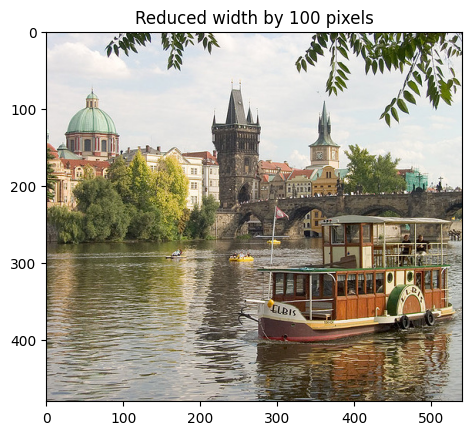

In [ ]:
first_image = plt.imread("inputSeamCarvingPrague.jpg") #Load the image
energyImg = energy_img(first_image) #Compute the energy matrix
for i in range(100): #Iterate to decrease width by 100 pixels
  first_image, energyImg = decrease_width(first_image, energyImg)
plt.imsave("outputReduceWidthPrague.png", first_image) #Save the image
plt.imshow(first_image) #Display as the image
plt.title("Reduced width by 100 pixels") #Create a title
plt.show() #Show the image

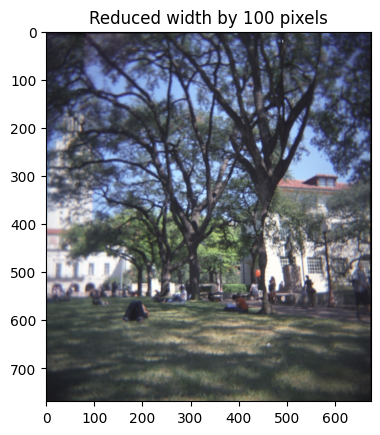

In [ ]:
second_image = plt.imread("inputSeamCarvingMall.jpg")
energyImg = energy_img(second_image)
for i in range(100):
  second_image, energyImg = decrease_width(second_image, energyImg)
plt.imsave("outputReduceWidthMall.png", second_image)
plt.imshow(second_image)
plt.title("Reduced width by 100 pixels")
plt.show()

# Task 2.

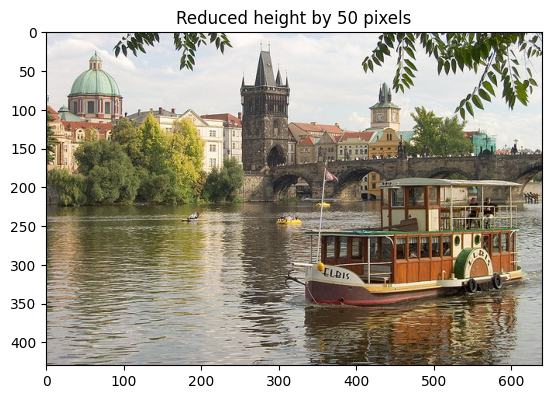

In [ ]:
first_image_task2 = plt.imread("inputSeamCarvingPrague.jpg")
energyImg = energy_img(first_image_task2)
for i in range(50):
  first_image_task2, energyImg = decrease_height(first_image_task2, energyImg)
plt.imsave("outputReduceHeightPrague.png", first_image_task2)
plt.imshow(first_image_task2)
plt.title("Reduced height by 50 pixels")
plt.show()

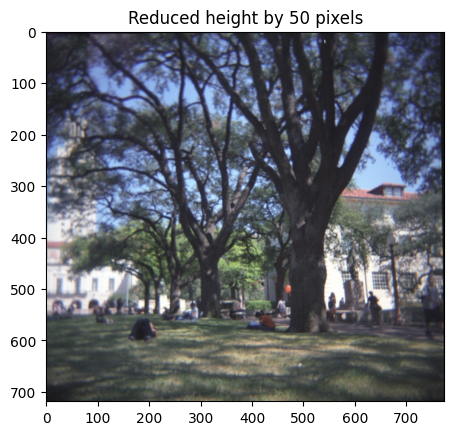

In [ ]:
second_image_task2 = plt.imread("inputSeamCarvingMall.jpg")
energyImg = energy_img(second_image_task2)
for i in range(50):
  second_image_task2, energyImg = decrease_height(second_image_task2, energyImg)
plt.imsave("outputReduceHeightMall.png", second_image_task2)
plt.imshow(second_image_task2)
plt.title("Reduced height by 50 pixels")
plt.show()

# Task 3.

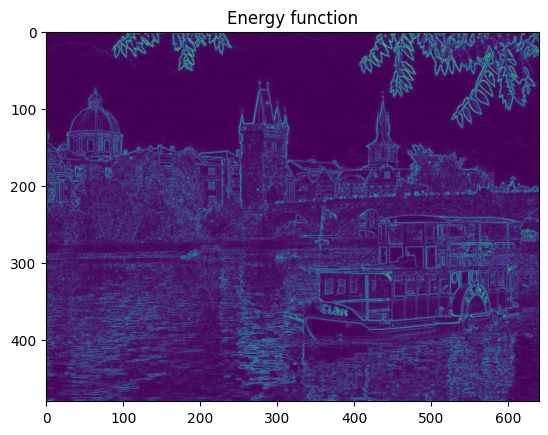

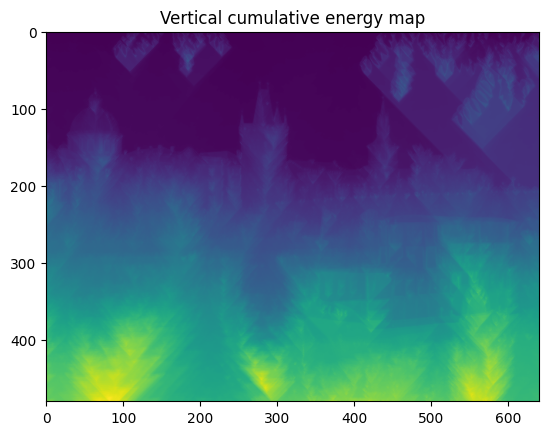

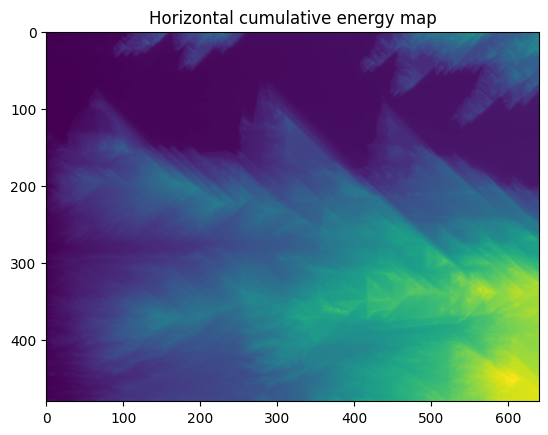

In [ ]:
first_image_energy = plt.imread("inputSeamCarvingPrague.jpg")
energyImg = energy_img(first_image_energy)
plt.imshow(energyImg)
plt.title("Energy function")
plt.show()
#Compute cumulative energy maps for both directions
vertical = cumulative_min_energy_map(energyImg, "VERTICAL")
horizontal = cumulative_min_energy_map(energyImg, "HORIZONTAL")
plt.imshow(vertical)
plt.title("Vertical cumulative energy map")
plt.show()
plt.imshow(horizontal)
plt.title("Horizontal cumulative energy map")
plt.show()

* Each pixel in the vertical cumulative energy map
represents the cost to reach that pixel from the top to the bottom. Darker regions show low energy(such as the sky), while brighter regions show high energy(such as the boat or glares on the water).
* Each pixel in the horizontal cumulative energy map represents the cost to reach that pixel from left to right. Darker regions show low energy(such as the sky), while brighter regions show high energy(such as the boat or buildings).
* Each map detects changes in the image corresponding to its specified direction. Seams will try to avoid regions with high energy.

# Task 4.

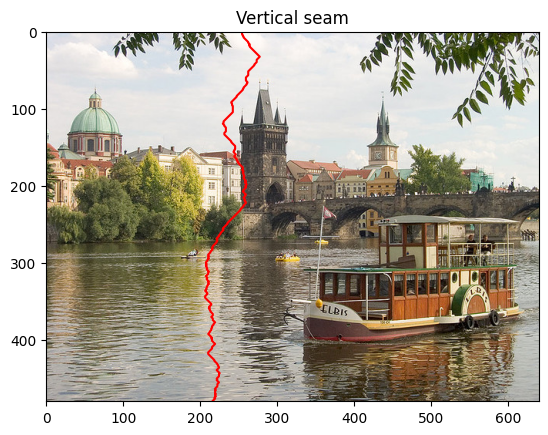

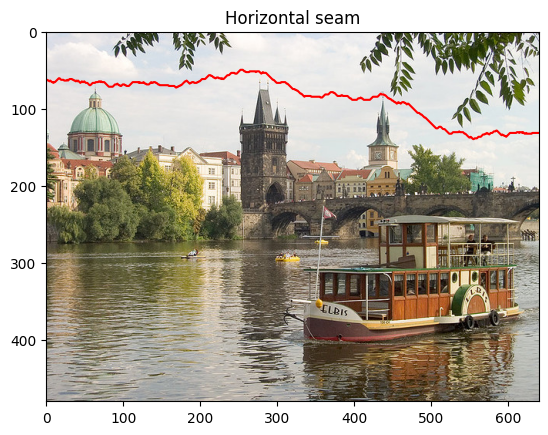

In [ ]:
first_image_seams = plt.imread("inputSeamCarvingPrague.jpg")
energyImg = energy_img(first_image_seams)
vertical = cumulative_min_energy_map(energyImg, "VERTICAL")
vertical_seam = find_vertical_seam(vertical) #Find column indexes
horizontal = cumulative_min_energy_map(energyImg, "HORIZONTAL")
horizontal_seam = find_horizontal_seam(horizontal) #Find row indexes
#Plot seams and display images
view_seam(first_image_seams, vertical_seam, "VERTICAL")
view_seam(first_image_seams, horizontal_seam, "HORIZONTAL")

* As I mentioned earlier, seams try to avoid regions with high energy. During backtracking for the vertical seam, we iterate from the bottom to the top. From the cumulative energy map, we can see that the seam starts in the lowest energy region at the bottom and goes upwards through low energy areas, such as between buildings and across the sky.
* The darkest region in the horizontal cumulative energy map is the sky. The seam follows the lowest energy path from left to right across the sky, where there are no visible objects.

# Task 5.

In [ ]:
#Function to compute energy using the Laplacian filter
def energy_img_modified_lap(im):
  im_double = im.astype(np.float64) #Convert image to a double datatype
  #Convert image to a grayscale by multiplying weights and pixel values
  grayscale_img = 0.299 * im_double[:, :, 0] + 0.587 * im_double[:, :, 1] + 0.114 * im_double[:, :, 2]
  filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) #Define a Laplacian filter
  energyImg = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1])) #Output energy map with the grayscale_img dimensions
  add_padding = np.pad(grayscale_img, pad_width = 1, mode = "edge") #Add 1 pixel padding by copying nearest pixel
  #Slide the window across the image
  for i in range(grayscale_img.shape[0]): #Iterate over rows
    for j in range(grayscale_img.shape[1]): #Iterate over columns
     #Apply filter to the 3x3 window and square
     energyImg[i, j] = (np.sum(filter * add_padding[i:i + 3, j:j + 3]))**2
  return energyImg

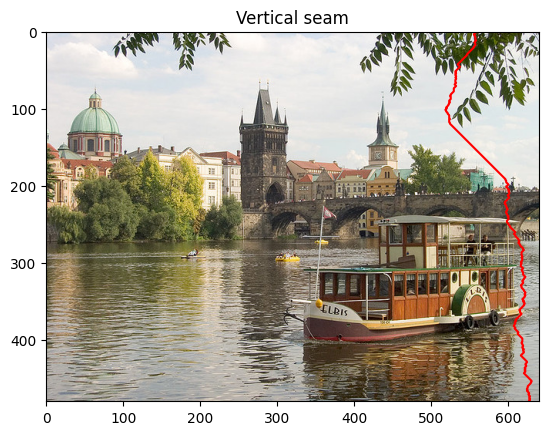

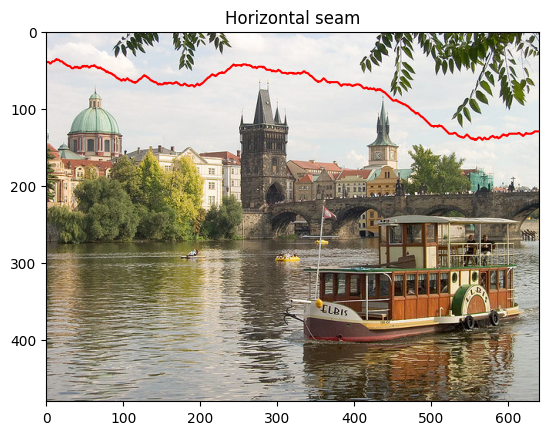

In [ ]:
first_image_seams_modified = plt.imread("inputSeamCarvingPrague.jpg")
energyImg = energy_img_modified_lap(first_image_seams_modified)
vertical = cumulative_min_energy_map(energyImg, "VERTICAL")
vertical_seam = find_vertical_seam(vertical)
horizontal = cumulative_min_energy_map(energyImg, "HORIZONTAL")
horizontal_seam = find_horizontal_seam(horizontal)
view_seam(first_image_seams_modified, vertical_seam, "VERTICAL")
view_seam(first_image_seams_modified, horizontal_seam, "HORIZONTAL")

* In this case, I applied the Laplacian filter to the image, which highlights edges more strongly than the gradient method. During backtracking, the vertical seam started in the most uniform part of the water and then tried to avoid high energy areas such as the boat and the leaves.
* The horizontal seam also follows a path across the sky since it is the lowest energy region. It does a better job of avoiding the tops of the buildings, because the Laplacian assigns a higher energy to their edges.

# Task 6.

In [ ]:
def energy_img_modified(im):
  im_double = im.astype(np.float64) #Convert image to a double datatype
  #Convert image to a grayscale by multiplying weights and pixel values
  grayscale_img = 0.299 * im_double[:, :, 0] + 0.587 * im_double[:, :, 1] + 0.114 * im_double[:, :, 2]
  #Define Prewitt filters for x and y
  filter_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
  filter_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
  #Gradient matrices for x and y with same dimensions as grayscale_img
  dx = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1]))
  dy = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1]))
  #Add 1 pixel padding by copying nearest pixel
  add_padding = np.pad(grayscale_img, pad_width = 1, mode = "edge")
  #Slide the window across the image
  for i in range(grayscale_img.shape[0]): #Iterate over rows
    for j in range(grayscale_img.shape[1]): #Iterate over columns
     #Apply filter to the 3x3 window in both directions
     dx[i, j] = np.sum(filter_x * add_padding[i:i + 3, j:j + 3])
     dy[i, j] = np.sum(filter_y * add_padding[i:i + 3, j:j + 3])
  energyImg = np.sqrt(dx**2 + dy**2) #Compute the final energy
  return energyImg

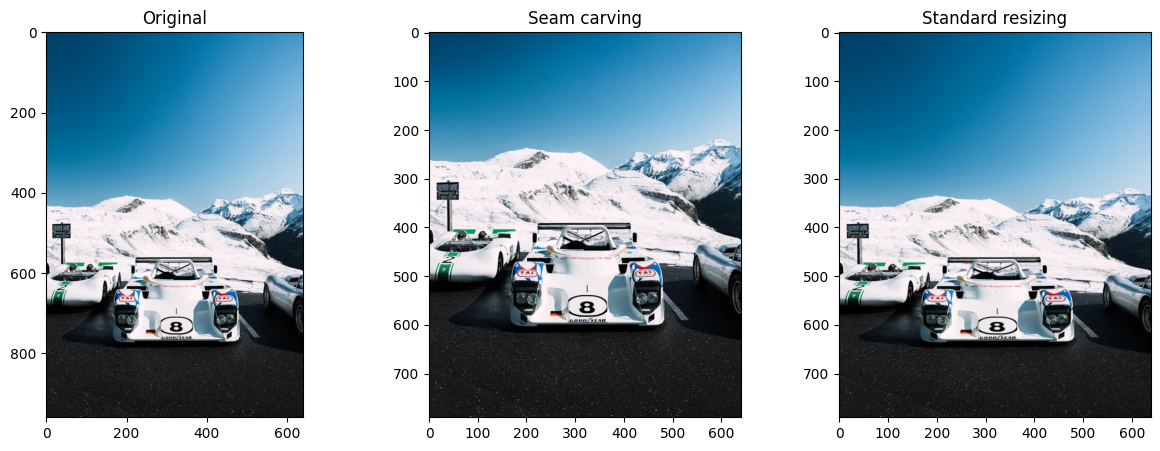

In [ ]:
car_image = plt.imread("inputSeamCarvingCar.jpg")
original = car_image.copy() #Make a copy of the original image
energyImg = energy_img_modified(car_image)
#Use standard resizing
resized = cv2.resize(car_image, (car_image.shape[1], car_image.shape[0] - 170))
#Iterate to decrease height by 170 pixels
for i in range(170):
  car_image, energyImg = decrease_height(car_image, energyImg)
#Output images in a row
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imsave("outputReduceHeightCar.png", car_image)
plt.imshow(car_image)
plt.title("Seam carving")
plt.subplot(1, 3, 3)
plt.imshow(resized)
plt.title("Standard resizing")
plt.show()

Here we observe that standard resizing changes the proportions of the car, while seam carving preserved them by removing only ground and sky pixels.

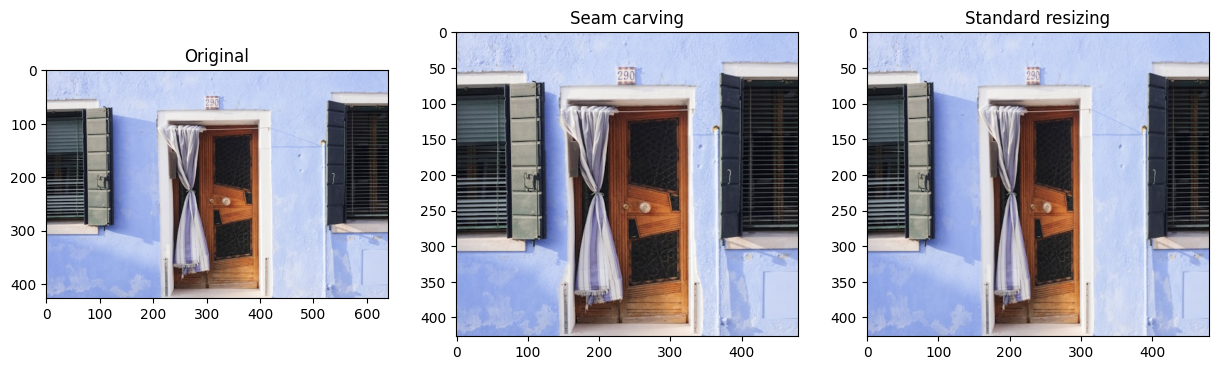

In [ ]:
door_image = plt.imread("inputSeamCarvingDoor.jpg")
original = door_image.copy()
energyImg = energy_img_modified_lap(door_image) #Here I used Laplacian filter
resized = cv2.resize(door_image, (door_image.shape[1] - 160, door_image.shape[0]))
#Iterate to decrease width by 160 pixels
for i in range(160):
  door_image, energyImg = decrease_width(door_image, energyImg)
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imsave("outputReduceWidthDoor.png", door_image)
plt.imshow(door_image)
plt.title("Seam carving")
plt.subplot(1, 3, 3)
plt.imshow(resized)
plt.title("Standard resizing")
plt.show()

In the output, we can see that standard resizing also changed the proportions of the main object. In the seam carving result, all proportions of the door are preserved. However, the distance between the door and the windows is reduced.

In [ ]:
#Function to compute energy using the Roberts filter
def energy_img_roberts(im):
  im_double = im.astype(np.float64) #Convert image to a double datatype
  #Convert image to a grayscale by multiplying weights and pixel values
  grayscale_img = 0.299 * im_double[:, :, 0] + 0.587 * im_double[:, :, 1] + 0.114 * im_double[:, :, 2]
  #Define Roberts filters for x and y
  filter_x = np.array([[0, 1], [-1, 0]])
  filter_y = np.array([[1, 0], [0, -1]])
  #Gradient matrices for x and y with same dimensions as grayscale_img
  dx = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1]))
  dy = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1]))
  #Add 1 pixel padding by copying nearest pixel
  add_padding = np.pad(grayscale_img, pad_width = 1, mode = "edge")
  #Slide the window across the image
  for i in range(grayscale_img.shape[0]): #Iterate over rows
    for j in range(grayscale_img.shape[1]): #Iterate over columns
      #Apply filter to the 2x2 window in both directions
     dx[i, j] = np.sum(filter_x * add_padding[i:i + 2, j:j + 2])
     dy[i, j] = np.sum(filter_y * add_padding[i:i + 2, j:j + 2])
  energyImg = np.sqrt(dx**2 + dy**2) #Compute the final energy
  return energyImg

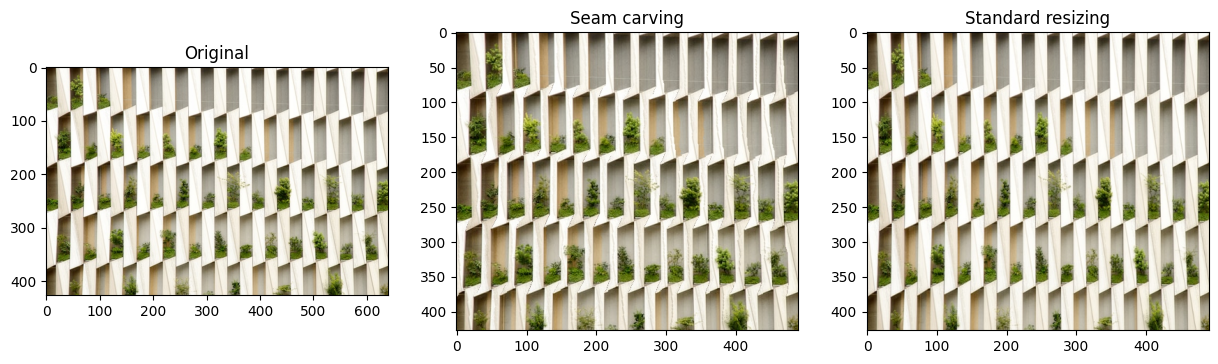

In [ ]:
building_image = plt.imread("inputSeamCarvingBuilding.jpg")
original = building_image.copy()
energyImg = energy_img_roberts(building_image)
resized = cv2.resize(building_image, (building_image.shape[1] - 150, building_image.shape[0]))
#Iterate to decrease width by 150 pixels
for i in range(150):
  building_image, energyImg = decrease_width(building_image, energyImg)
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imsave("outputReduceWidthBuilding.png", building_image)
plt.imshow(building_image)
plt.title("Seam carving")
plt.subplot(1, 3, 3)
plt.imshow(resized)
plt.title("Standard resizing")
plt.show()

In the seam carving result, we observe that the vertical objects in the image become thinned. Seam carving fails at reducing width of such images. In contrast, standard resizing produced more acceptable result.

Notes: I used Internet to refresh my knowledge of NumPy, Matplotlib and OpenCV libraries, along with array slicing methods. ChatGPT gave me a hint on how to retrieve index with the minimum value from values = [cumulativeEnergyMap[i, starting_point], cumulativeEnergyMap[i, starting_point + 1]]. I used the hint and implemented this functionality by myself. Energy function, cumulative minimum energy algorithm, and ideas for filters I took from the canvas slides.